# Mohamaco — Weekly Analysis

This notebook analyzes store performance based on `model_data.json` and produces:
- KPI dashboard (with correctly aggregated staff cost)
- Per-product overview table (with profit coloring, HTML + PNG export)
- Weekly Sold % heatmap (annotated)
- Sales Heatmap by Day (annotated) — uses preloaded `transactions` and `products` DataFrames

**Note:** For the daily sales heatmap, make sure both  
`transactions` (`version`, `product`, `day`, `qty`) and  
`products` (`version`, `product`, `amount`) are available in memory  
(or loaded from JSON before running this section).

In [1]:
# === Setup & Load ============================================================
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

MODEL_DATA = Path("model_data.json")
assert MODEL_DATA.exists(), "model_data.json not found. Run the generator first."

md = pd.DataFrame(json.load(open(MODEL_DATA, "r", encoding="utf-8")))
VERSIONS = sorted(md["version"].unique())
V_NOW  = VERSIONS[-1]
V_PREV = VERSIONS[-2] if len(VERSIONS) > 1 else VERSIONS[-1]

print("Versions:", VERSIONS, "| Compare:", V_PREV, "→", V_NOW)
display(md.head(3))

# ---------------------------------------------------------------------------
DATA_DIR = Path("data")
AMOUNTS_DIR = DATA_DIR / "amounts"
PRICES_DIR = DATA_DIR / "prices"
TRANSACTIONS_DIR = DATA_DIR / "transactions"
SCHEDULES_DIR = DATA_DIR / "schedules"
WORKERS_DIR = DATA_DIR / "workers"
SUPPLIER_PATH = DATA_DIR / "supplier_prices.json"

# --- Discover available versions --------------------------------------------
def det_versions():
    vs = set()
    for p in [AMOUNTS_DIR, PRICES_DIR, TRANSACTIONS_DIR, SCHEDULES_DIR]:
        if not p.exists(): 
            continue
        for f in p.glob("*_[0-9].json"):
            try:
                v = int(f.stem.split("_")[-1])
                vs.add(v)
            except Exception:
                pass
    return sorted(vs)

VERSIONS = det_versions()
print("Detected versions:", VERSIONS)
if not VERSIONS:
    raise RuntimeError("No versions found under data/{amounts,prices,transactions,schedules}.")

# --- Helpers -----------------------------------------------------------------
def read_json(path: Path): 
    with open(path, "r", encoding="utf-8") as f: 
        return json.load(f)

def load_version_tables(v: int) -> pd.DataFrame:
    a = read_json(AMOUNTS_DIR / f"amounts_{v}.json")
    p = read_json(PRICES_DIR / f"prices_{v}.json")
    amounts = pd.DataFrame(list(a.items()), columns=["product","amount"])
    prices  = pd.DataFrame(list(p.items()), columns=["product","price"])
    return amounts.merge(prices, on="product", how="outer").assign(version=v)

def load_transactions(v: int) -> pd.DataFrame:
    raw = read_json(TRANSACTIONS_DIR / f"transactions_{v}.json")
    rows = []
    for day, txs in raw.items():  # <-- day key from 1 to 7
        for tx in txs:
            types, amts = tx.get("merch_types", []), tx.get("merch_amounts", [])
            for t, a in zip(types, amts):
                rows.append({
                    "product": str(t),
                    "qty": float(a),
                    "version": v,
                    "day": int(day),  # <-- add day
                    "worker": tx.get("register_worker"),
                    "customer_id": tx.get("customer_id")  # <-- add buyer id
                })
    return pd.DataFrame(rows)


# --- Core tables -------------------------------------------------------------
supplier = pd.DataFrame(list(read_json(SUPPLIER_PATH).items()), columns=["product","supplier_price"])

products = pd.concat([load_version_tables(v) for v in VERSIONS], ignore_index=True)
transactions = pd.concat([load_transactions(v)   for v in VERSIONS if (TRANSACTIONS_DIR / f"transactions_{v}.json").exists()],
                         ignore_index=True)

# Merge to build analysis frame
df = (products
      .merge(transactions.groupby(["version","product"])["qty"].sum().reset_index(), 
             on=["version","product"], how="left")
      .merge(supplier, on="product", how="left"))

df["qty"] = df["qty"].fillna(0.0)
df["revenue"] = df["qty"] * df["price"]
df["product_cost"] = df["qty"] * df["supplier_price"]
df["gross_profit"] = df["revenue"] - df["product_cost"]

print("Data merged.")
display(df.head(3))

Versions: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)] | Compare: 5 → 6


,product,amount,price,version,qty,supplier_price,revenue,product_cost,gross_profit,sell_through,price_cost_ratio,gross_margin_%,profit_per_stock_unit,demand_supply_index,D_out_est,TAST_norm,version_staff_cost,profit_per_worker
0,batteries,2096,15.85,0,2096.0,12.0,33221.60,25152.0,8069.60,1.0,1.320833,24.290221,3.85,1.320833,3.0,1.0,194596.337915,0.041468
1,dinosaur,1947,94.60,0,0.0,65.0,0.00,0.0,0.00,0.0,1.455385,31.289641,0.00,0.000000,8.0,0.0,194596.337915,0.000000
2,gjokur_ja,69,814.31,0,69.0,580.0,56187.39,40020.0,16167.39,1.0,1.403983,28.774054,234.31,1.403983,3.0,1.0,194596.337915,0.083082


Detected versions: [0, 1, 2, 3, 4, 5, 6]
Data merged.


,product,amount,price,version,qty,supplier_price,revenue,product_cost,gross_profit
0,batteries,2096,15.85,0,2096.0,12.0,33221.60,25152.0,8069.60
1,dinosaur,1947,94.60,0,0.0,65.0,0.00,0.0,0.00
2,gjokur_ja,69,814.31,0,69.0,580.0,56187.39,40020.0,16167.39


,version,qty,revenue,product_cost,gross_profit,staff_cost,net_profit,net_margin_%
0,0,20397.0,1444527.59,1061334.0,383193.59,194596.34,188597.25,13.06
1,1,20419.0,1053705.70,743237.0,310468.70,194596.34,115872.36,11.00
2,2,21353.0,801424.92,569282.0,232142.92,194596.34,37546.58,4.68
3,3,19187.0,1036064.91,748386.0,287678.91,194596.34,93082.57,8.98
4,4,29138.0,956008.62,668487.0,287521.62,194596.34,92925.28,9.72
5,5,30686.0,1533697.87,1088108.0,445589.87,194596.34,250993.53,16.37
6,6,32848.0,1534150.17,1140933.0,393217.17,194596.34,198620.83,12.95


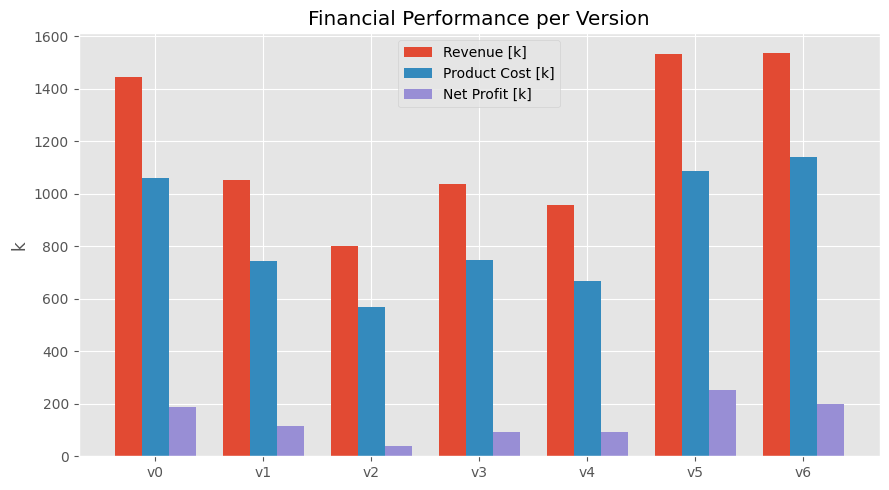

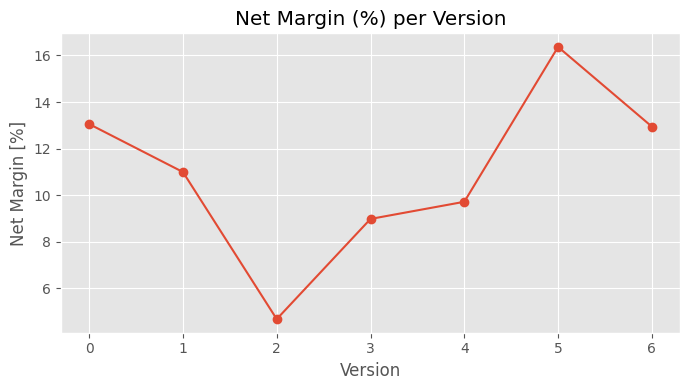

In [2]:
# === KPI Dashboard (correct staff cost aggregation) ==========================
sum_core = (
    md.groupby("version")[["qty","revenue","product_cost","gross_profit"]]
      .sum()
      .reset_index()
)

staff_once = (
    md.groupby("version")["version_staff_cost"]
      .max()  # exakt einmal pro Version
      .rename("staff_cost")
      .reset_index()
)

sumv = sum_core.merge(staff_once, on="version", how="left")
sumv["net_profit"]   = sumv["gross_profit"] - sumv["staff_cost"]
sumv["net_margin_%"] = np.where(sumv["revenue"]>0, sumv["net_profit"]/sumv["revenue"]*100, np.nan)

display(sumv.round(2))

# === KPI Plots ===============================================================
x = np.arange(len(sumv)); w = 0.25

fig, ax = plt.subplots(figsize=(9,5))
ax.bar(x-w, sumv["revenue"]/1000,  w, label="Revenue [k]")
ax.bar(x,   sumv["product_cost"]/1000, w, label="Product Cost [k]")
ax.bar(x+w, sumv["net_profit"]/1000,   w, label="Net Profit [k]")
ax.set_xticks(x); ax.set_xticklabels([f"v{i}" for i in sumv["version"]])
ax.set_ylabel("k"); ax.set_title("Financial Performance per Version")
ax.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,4))
plt.plot(sumv["version"], sumv["net_margin_%"], marker="o")
plt.title("Net Margin (%) per Version")
plt.xlabel("Version"); plt.ylabel("Net Margin [%]"); plt.tight_layout(); plt.show()

## Overview per Product (Selected Week)

Shows `Amount`, `Sold_Amount`, `Price`, `Supplier_Price` and **True_Profit**.
- Cells are colored: **green** if profit > 0, **red** if ≤ 0.  
- Exports to **HTML** (always) and **PNG** (robust; no Chrome required).

In [3]:
# === Overview Table (diverging red↔green by profit) + Export =================

V_SHOW = V_NOW  # change to a specific week if needed, e.g., 5

cur = (md[md["version"]==V_SHOW]
       .groupby("product", as_index=False)
       .agg(Amount=("amount","sum"),
            Sold_Amount=("qty","sum"),
            Price=("price","mean"),
            Supplier_Price=("supplier_price","mean")))

cur["Total_Purchase_Cost"] = cur["Supplier_Price"] * cur["Amount"]  # cost of all purchased units
cur["Revenue"] = cur["Price"] * cur["Sold_Amount"]                  # actual sales revenue
cur["Real_Profit"] = cur["Revenue"] - cur["Total_Purchase_Cost"]    # includes unsold stock cost
cur = cur.sort_values("Real_Profit", ascending=False).reset_index(drop=True)

# --- Color helpers (diverging red↔green around 0) ---------------------------
def _hex_to_rgb(h):
    h=h.lstrip("#"); return tuple(int(h[i:i+2],16) for i in (0,2,4))

def _rgb_to_hex(rgb):
    return "#{:02x}{:02x}{:02x}".format(*[max(0,min(255,int(round(x)))) for x in rgb])

def _interp(c1, c2, t):
    a=_hex_to_rgb(c1); b=_hex_to_rgb(c2)
    return _rgb_to_hex(tuple(a[i] + (b[i]-a[i])*t for i in range(3)))

# light→dark ramps
RED_LIGHT,  RED_DARK  = "#fde0e0", "#a10000"
GRN_LIGHT,  GRN_DARK  = "#e7f6e7", "#1b7a1b"
NEUTRAL                = "#ffffff"

def _diverging_color_list(vals: pd.Series):
    pos_vals = vals[vals>0]
    neg_vals = -vals[vals<0]
    pos_max  = float(pos_vals.max()) if not pos_vals.empty else 1.0
    neg_max  = float(neg_vals.max()) if not neg_vals.empty else 1.0

    def color_one(v):
        if v > 0:
            t = 0.0 if pos_max<=0 else min(1.0, v/pos_max)
            return _interp(GRN_LIGHT, GRN_DARK, t)
        elif v < 0:
            t = 0.0 if neg_max<=0 else min(1.0, (-v)/neg_max)
            return _interp(RED_LIGHT, RED_DARK, t)
        else:
            return NEUTRAL

    return [f"background-color: {color_one(v)}" for v in vals]

# --- Styler with diverging background on True_Profit -------------------------
styled = (cur.style
          .format({"Amount":"{:,.0f}",
                   "Sold_Amount":"{:,.0f}",
                   "Price":"{:.2f}",
                   "Supplier_Price":"{:.2f}",
                   "Total_Purchase_Cost":"{:,.2f}",
                   "Revenue":"{:,.2f}",
                   "Real_Profit":"{:,.2f}"})
          .apply(_diverging_color_list, subset=["Real_Profit"])
         )

display(styled)

# --- Export (HTML always, PNG robust) ---------------------------------------
OUT_DIR = Path("output"); OUT_DIR.mkdir(parents=True, exist_ok=True)
html_path = OUT_DIR / f"overview_v{V_SHOW}.html"
with open(html_path, "w", encoding="utf-8") as f:
    f.write(styled.to_html())
print("Saved HTML table:", html_path)

# PNG export: try dataframe_image (matplotlib backend), fallback to pure Matplotlib
png_path = OUT_DIR / f"overview_v{V_SHOW}.png"

def _format_df_for_png(df: pd.DataFrame) -> pd.DataFrame:
    df2 = df.copy()
    df2["Amount"]         = df2["Amount"].map("{:,.0f}".format)
    df2["Sold_Amount"]    = df2["Sold_Amount"].map("{:,.0f}".format)
    df2["Price"]          = df2["Price"].map("{:.2f}".format)
    df2["Supplier_Price"] = df2["Supplier_Price"].map("{:.2f}".format)
    df2["Total_Purchase_Cost"] = df2["Total_Purchase_Cost"].map("{:.2f}".format)
    df2["Revenue"]        = df2["Revenue"].map("{:.2f}".format)
    df2["Real_Profit"]    = df2["Real_Profit"].map("{:.2f}".format)
    return df2

# Precompute exact colors for PNG fallback (to match Styler)
profit_colors = _diverging_color_list(cur["Real_Profit"])
profit_colors_hex = [c.split(": ")[1] for c in profit_colors]  # extract "#xxxxxx"

try:
    import dataframe_image as dfi
    dfi.export(styled, str(png_path), table_conversion="matplotlib", fontsize=10, dpi=300)
    print("Saved PNG via dataframe_image (matplotlib):", png_path)
except Exception as e:
    print("dataframe_image failed, fallback to pure Matplotlib…", e)
    from matplotlib import colors as mcolors
    df_fmt = _format_df_for_png(cur)
    cols   = list(df_fmt.columns)
    values = df_fmt.values.tolist()

    n_rows, n_cols = len(df_fmt), len(cols)
    fig_w = min(16, 1.2 * n_cols + 4)
    fig_h = max(2.5, 0.42 * n_rows + 1.5)

    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    ax.axis("off")
    tbl = ax.table(cellText=values, colLabels=cols, cellLoc="center", loc="center")
    tbl.auto_set_font_size(False); tbl.set_fontsize(9); tbl.scale(1.0, 1.2)

    # Header style
    for (r,c), cell in tbl.get_celld().items():
        if r == 0:
            cell.set_text_props(weight="bold", color="black")
            cell.set_facecolor("#f2f2f2")

    # Apply diverging shades to the Real_Profit column
    tp_idx = cols.index("Real_Profit")
    for i in range(n_rows):
        tbl[i+1, tp_idx].set_facecolor(profit_colors_hex[i])

    plt.tight_layout()
    fig.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.close(fig)
    print("Saved PNG via pure Matplotlib:", png_path)

,product,Amount,Sold_Amount,Price,Supplier_Price,Total_Purchase_Cost,Revenue,Real_Profit
0,sunscreen,"3,343","3,329",47.67,35.00,"117,005.00","158,693.43","41,688.43"
1,laderhosen,466,466,301.10,220.00,"102,520.00","140,312.60","37,792.60"
2,rice_porridge,"4,079","4,079",22.79,15.00,"61,185.00","92,960.41","31,775.41"
3,knives,"1,831","1,831",53.68,38.00,"69,578.00","98,288.08","28,710.08"
4,gjokur_ja,94,94,867.60,580.00,"54,520.00","81,554.40","27,034.40"
5,hot_dogs,"3,239","3,239",25.19,18.00,"58,302.00","81,590.41","23,288.41"
6,monster,"3,582","3,582",21.55,16.00,"57,312.00","77,192.10","19,880.10"
7,batteries,"3,472","3,472",17.30,12.00,"41,664.00","60,065.60","18,401.60"
8,ice_cream,"3,664","3,664",11.85,8.00,"29,312.00","43,418.40","14,106.40"
9,nails,"4,555","4,555",8.31,6.00,"27,330.00","37,852.05","10,522.05"


Saved HTML table: output/overview_v6.html
Saved PNG via dataframe_image (matplotlib): output/overview_v6.png


## Weekly Sold % Heatmap (Annotated)

Displays sell-through rate per product and version.  
`% Sold = (qty / amount) × 100`, clipped to 0–100.

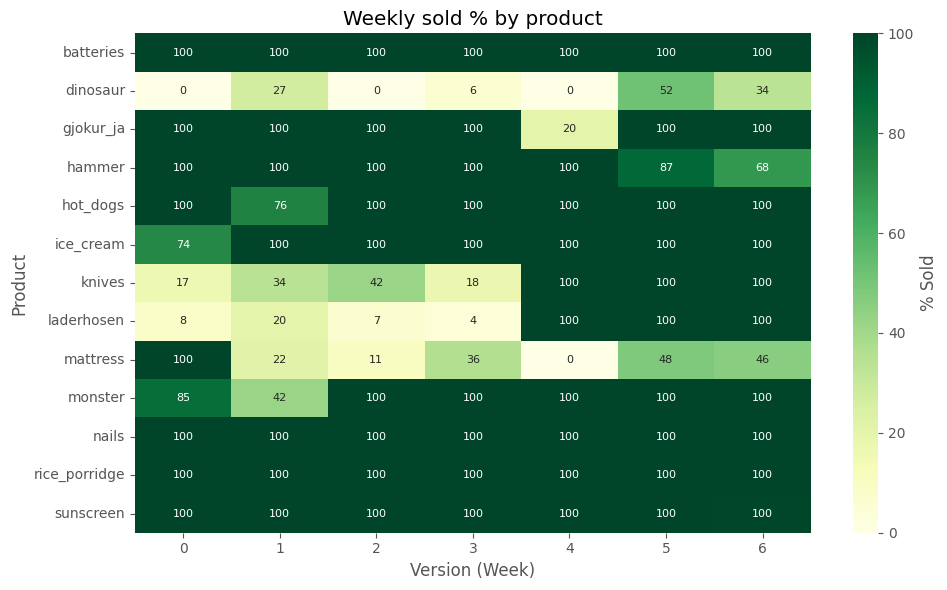

In [4]:
# === Weekly Sold % Heatmap (annotated) ======================================
p = (md.groupby(["product","version"], as_index=False)
       .agg(qty=("qty","sum"), amount=("amount","sum")))
p["sold_pct"] = np.where(p["amount"]>0, p["qty"]/p["amount"]*100, 0.0).clip(0,100)

pivot = p.pivot(index="product", columns="version", values="sold_pct").fillna(0.0)

plt.figure(figsize=(10,6))
ax = sns.heatmap(
    pivot,
    cmap="YlGn", vmin=0, vmax=100,
    annot=True, fmt=".0f",
    annot_kws={"size":8},
    cbar_kws={"label":"% Sold"}
)
ax.set_title("Weekly sold % by product")
ax.set_xlabel("Version (Week)")
ax.set_ylabel("Product")
plt.tight_layout(); plt.show()

## Sales Heatmap by Day (Selected Weeks)

Uses preloaded `transactions` (version, product, day, qty)  
and `products` (version, product, amount) DataFrames.

Displays per-day sales quantities for each product with annotations.

=== Week 5 Product Summary ===


,product,stock_amount,sold_amount,avg_sold_per_day,sold_out_day
0,batteries,3216,3216.0,459.43,6
1,dinosaur,484,253.0,36.14,-
2,gjokur_ja,100,100.0,14.29,6
3,hammer,3937,3415.0,487.86,-
4,hot_dogs,3004,3004.0,429.14,6
5,ice_cream,3394,3394.0,484.86,7
6,knives,1628,1628.0,232.57,6
7,laderhosen,414,414.0,59.14,5
8,mattress,2594,1255.0,179.29,-
9,monster,3111,3111.0,444.43,5


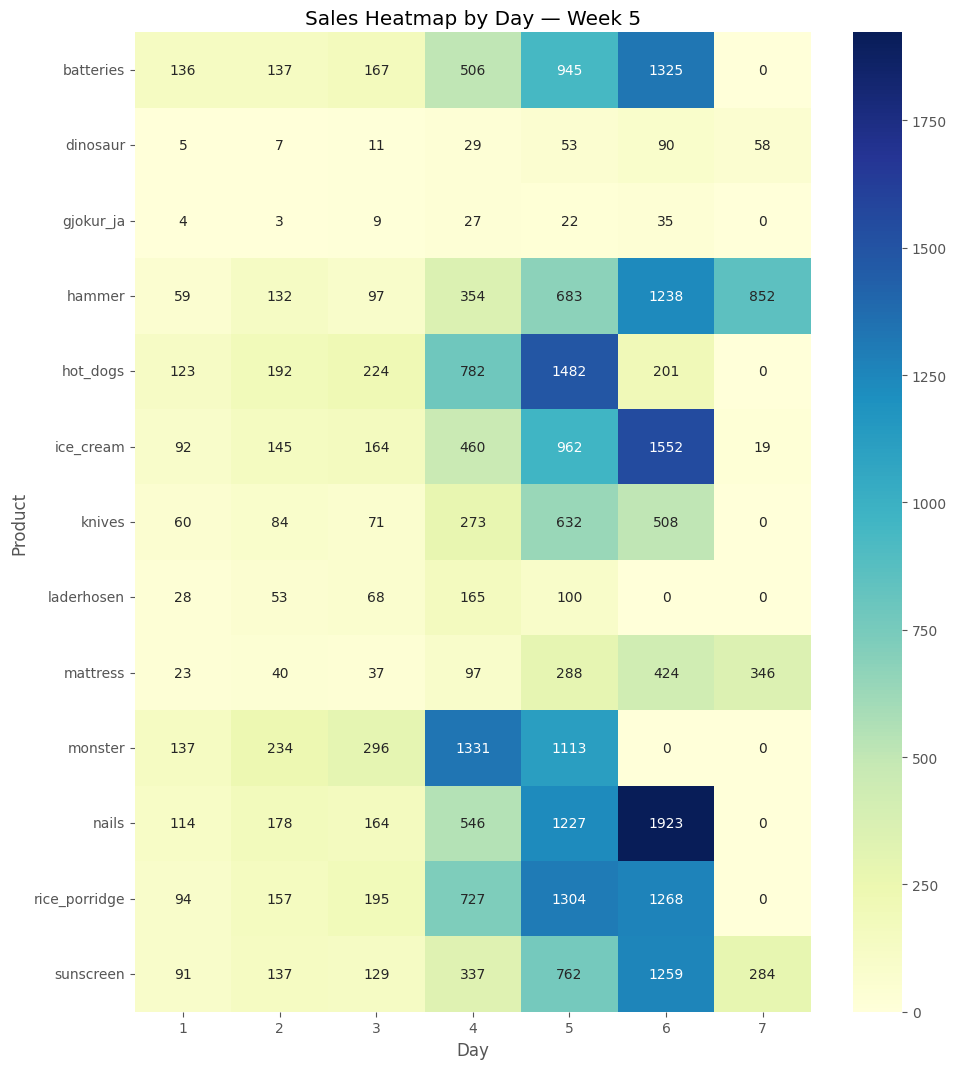

In [5]:
import seaborn as sns

transactions["qty"] = pd.to_numeric(transactions["qty"], errors="coerce").fillna(0)

selected_weeks =  [5]#4  # change this to your desired week(s)

if isinstance(selected_weeks, int):
    selected_weeks = [selected_weeks]

for v in selected_weeks:
    if v not in VERSIONS:
        print(f"Week {v} not found, skipping...")
        continue

    tx_week = transactions[transactions["version"] == v]
    if tx_week.empty:
        print(f"No transactions for week {v}")
        continue

    amounts_week = products[products["version"] == v][["product","amount"]]

    sales_per_day = (
        tx_week.groupby(["product", "day"])["qty"]
        .sum()
        .reset_index()
        .sort_values(["product","day"])
    )

    total_days = 7

    summary_rows = []
    for product, grp in sales_per_day.groupby("product"):
        all_days = pd.DataFrame({"day": range(1, total_days + 1)})
        merged = all_days.merge(grp, on="day", how="left").fillna({"qty": 0})
        avg_sold = merged["qty"].sum() / len(merged)
        stock_amount = amounts_week.loc[amounts_week["product"]==product,"amount"].values[0]
        sold_amount = merged["qty"].sum()
        last_sale_day = grp["day"].max() if sold_amount > 0 else 0
        sold_out_day = last_sale_day if sold_amount >= stock_amount else "-"

        summary_rows.append({
            "product": product,
            "stock_amount": stock_amount,
            "sold_amount": sold_amount,
            "avg_sold_per_day": round(avg_sold,2),
            "sold_out_day": sold_out_day
        })

    week_summary_df = pd.DataFrame(summary_rows)
    print(f"=== Week {v} Product Summary ===")
    display(week_summary_df)

    heatmap_data = sales_per_day.pivot(index="product", columns="day", values="qty").reindex(columns=range(1,8), fill_value=0).fillna(0).astype(int)
    plt.figure(figsize=(10, len(heatmap_data)*0.6 + 3))
    sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu")
    plt.title(f"Sales Heatmap by Day — Week {v}")
    plt.xlabel("Day")
    plt.ylabel("Product")
    plt.tight_layout()
    plt.show()

## Impact — Latest vs Previous Week

Top gainers/decliners by revenue delta to explain where the improvement came from.

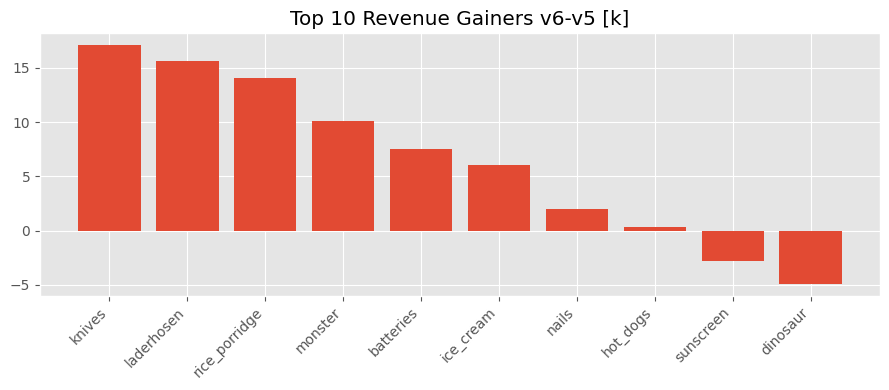

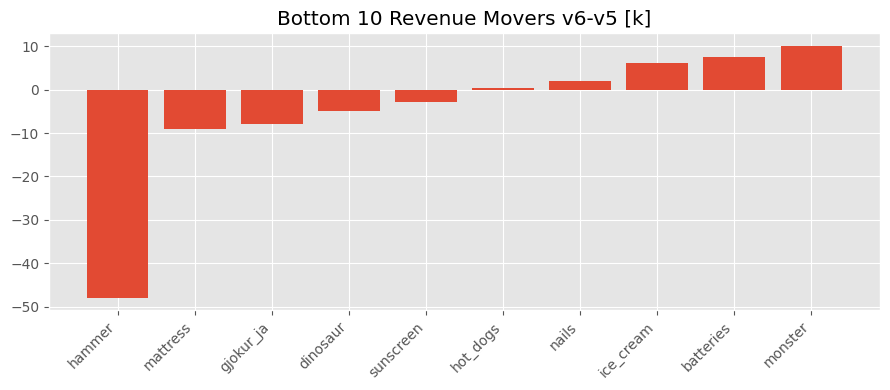

In [6]:
keep = ["product","amount","price","qty","revenue","gross_profit","supplier_price"]
prev = md[md["version"]==V_PREV][keep].groupby("product",as_index=False).sum()
now  = md[md["version"]==V_NOW][keep].groupby("product",as_index=False).sum()

cmp = now.merge(prev, on="product", suffixes=("_now","_prev"), how="outer").fillna(0.0)
cmp["revenue_delta"] = cmp["revenue_now"] - cmp["revenue_prev"]

topN = 10
pos = cmp.sort_values("revenue_delta", ascending=False).head(topN)
neg = cmp.sort_values("revenue_delta", ascending=True).head(topN)

plt.figure(figsize=(9,4)); plt.bar(pos["product"], pos["revenue_delta"]/1000)
plt.title(f"Top {topN} Revenue Gainers v{V_NOW}-v{V_PREV} [k]"); plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4)); plt.bar(neg["product"], neg["revenue_delta"]/1000)
plt.title(f"Bottom {topN} Revenue Movers v{V_NOW}-v{V_PREV} [k]"); plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()